# OSM Econ PS 3: OG Model
### Rebekah Dix

### Setup

In [1]:
import numpy as np
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt
import scipy.linalg as la

### Parameters

In [2]:
beta = .442
#beta = .55
delta = .6415
sigma = 3
A = 1
alpha = .35

nvec = np.array([1.0, 1.0, .2])

L = 2.2
SS_tol = .001

f_params = nvec, A, alpha, delta

### Calculate wage and interest rate

In [3]:
def get_w(K, w_args):
    '''This function calculates the equilibrium wage given a level
    of aggregate capital and model parameters.'''
    A, alpha = w_args
    
    w = (1 - alpha) * A * (((K) / (2.2)) ** alpha)
    
    return w

def get_r(K, r_args):
    '''This function calculates the equilibrium interest rate given a level
    of aggregate capital and model parameters..'''
    A, alpha, delta = r_args
    
    r = alpha * A * ((2.2 / (K)) ** (1 - alpha)) - delta
    
    return r

### Exercise 2.1

In [4]:
def feasible(f_params, bvec_guess):
    '''This function checks the nonnegativity constraints on 
    consumption and capital for a given vector of savings.
    
    Parameters:
        bvec_guess: a 2 element numpy array with a guess for the steady-state savings vector
        f_params: a tuple with the model parameters nvec, A, alpha, delta
    
    Returns:
        b_cnstr: Boolean vector of length 2, represents which element 
            of bvec_guess is likely responsible for violations of
            nonnegativity constraints on consumption
        c_cnstr: Boolean vector of length 3, represents violations of
            nonnegativity constraints on consumption over three periods
        K_cnstr: Boolean vector of length 1, represents violations of
            nonnegativity constraints on aggregate capital
    '''
    
    # unpack parameters
    b2, b3 = bvec_guess
    nvec, A, alpha, delta = f_params
    
    K_cnstr, c_cnstr, b_cnstr = np.full(1, False), np.full(3, False), np.full(2, False)
    
    # Calculate interest rate and wage corresponding to bvec_guess
    w_args = A, alpha
    r_args = A, alpha, delta
    w = get_w(b2 + b3, w_args)
    r = get_r(b2 + b3, r_args)
    
    # calculate consumption from the budget constraints
    c_cnstr[0] = nvec[0] * w - b2 < 0 
    c_cnstr[1] = nvec[1] * w + (1 + r) * b2 - b3 < 0
    c_cnstr[2] = nvec[2] * w + (1 + r) * b3 < 0
    
    # calculate capital from market clearing condition
    K_cnstr[0] = b2 + b3 < 0
    
    if c_cnstr[0] == True:
        b_cnstr[0] = True
    if c_cnstr[1] == True:
        b_cnstr[0], b_cnstr[1] = True, True
    if c_cnstr[2] == True:
        b_cnstr[1] = True
        
    return b_cnstr, c_cnstr, K_cnstr

#### Exercise 2.1 (a)

In [5]:
bvec_guess1 = np.array([1.0, 1.2])
feasible(f_params, bvec_guess1)

(array([ True, False]), array([ True, False, False]), array([False]))

The nonnegativity constraint on consumption in the first period is violated, likely caused by savings in the first period of 1.

#### Exercise 2.1 (b)

In [6]:
bvec_guess2 = np.array([0.06, -.001])
feasible(f_params, bvec_guess2)

(array([False, False]), array([False, False, False]), array([False]))

No nonnegativity constraints are violated.

#### Exercise 2.1 (c)

In [7]:
bvec_guess3 = np.array([0.1, 0.1])
feasible(f_params, bvec_guess3)

(array([False, False]), array([False, False, False]), array([False]))

No nonnegativity constraints are violated.

### Exercise 2.2: Calculate Steady-State Equilibrium

In [8]:
def Eul_errs(bvec, *err_args):
    '''This function calculates and returns the two Euler errors
    for a given vector of savings.
    
    Parameters:
        bvec_guess: a 2 element numpy array with a guess for the savings vector
        that satisfies the intertemporal Euler equations
        err_args: a tuple with the model parameters beta, sigma, A, alpha, delta
        
    Returns:
        err1: (float) error in intertemporal Euler equation from using bvec
        err2: (float) error in intertemporal Euler equation from using bvec
    '''
    
    # Unpack parameters
    beta, sigma, A, alpha, delta = err_args
    b2, b3 = bvec
    
    # Calculate wage and interest rate for a savings vector
    w_args = A, alpha
    r_args = A, alpha, delta
    w = get_w(b2 + b3, w_args) 
    r = get_r(b2 + b3, r_args) 
    
    # Calculate consumption in each period from budget constraints
    c1 = w - b2
    c2 = w + (1 + r) * b2 - b3
    c3 = (1 + r) * b3 + 0.2 * w
    
    # Calculate marginal utilities
    MU1 = c1 ** (-sigma)
    MU2 = c2 ** (-sigma)
    MU3 = c3 ** (-sigma)
    
    # Calculuate errors from intertemporal Euler equations
    err1 = MU1 - beta * (1 + r) * MU2
    err2 = MU2 - beta * (1 + r) * MU3
    
    return err1, err2

In [9]:
def get_SS(params, bvec_guess, SS_graphs):
    '''This function solves for the steady-state equilibrium.
    
    Parameters:
        params: a tuple with model parameters beta, sigma, nvec, L, A, alpha, delta, SS_tol
        bvec_guess: a 2 element numpy array with a guess for the steady-state
            savings vector
        SS_graphs: (boolean) True if use wants graphs produced of steady-state levels
            of savings and consumption
    
    Output:
        A Python dictionary with the steady-state solution values for the endogenous objects
        in the model.
    '''
    
    start_time = time.clock()
    
    # Unpack parameters
    b2, b3 = bvec_guess
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    
    err_args = beta, sigma, A, alpha, delta
    w_args = A, alpha
    r_args = A, alpha, delta
    
    results_ss = opt.root(Eul_errs, bvec_guess, tol=SS_tol, args=(err_args))
    
    # Calculate steady-state levels of equilibrium objects
    b_ss = results_ss.x
    w_ss = get_w(sum(b_ss), w_args)
    r_ss = get_r(sum(b_ss), r_args)
    c_ss = np.array([w_ss - b_ss[0], 
                     w_ss + (1 + r_ss)*b_ss[0] - b_ss[1],
                     (1 + r_ss)*b_ss[1] + .2 * w_ss])
    K_ss = np.sum(b_ss)
    Y_ss = A * (K_ss ** alpha) * (L ** (1 - alpha))
    C_ss = Y_ss - K_ss + (1 - delta) * K_ss
    
    # Calcuate two Euler errors from the resulting steady-state solution
    # and resource constraint error
    EulErr_ss = np.array([beta * (1 + r_ss) * (c_ss[1] ** -sigma) - (c_ss[0] ** -sigma),
                          beta * (1 + r_ss) * (c_ss[2] ** -sigma) - (c_ss[1] ** -sigma)])
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_time = time.clock()
    
    # Create dictionary for output
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss, 
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss, 
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss, 
        'ss_time': ss_time}
     
    # Graph steady-state levels of savings and consumption
    if SS_graphs == True:
        fig, ax = plt.subplots(figsize=(6,6))
        s = np.array([1, 2, 3])
        plt.plot(s, c_ss, label=r'$\bar{c}_s$', marker='*')
        plt.plot(s[1:], b_ss, label=r'$\bar{b}_s$', marker='*')
        plt.title("Steady-State Consumption and Savings")
        plt.legend()
        plt.grid()
        plt.xlabel("Age (s)")
        plt.ylabel("Level")
        plt.xticks(s)
        plt.show()
        
    return ss_output

In [10]:
params = beta, sigma, nvec, L, A, alpha, delta, SS_tol

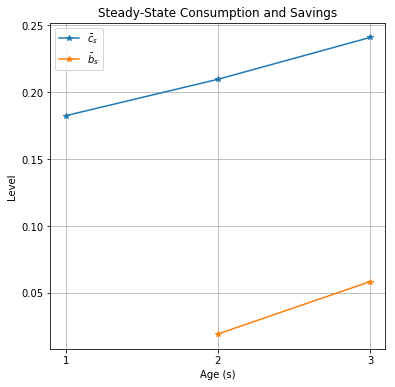

{'b_ss': array([0.01931262, 0.05841243]), 'c_ss': array([0.18241333, 0.20961424, 0.24087656]), 'w_ss': 0.20172594930955895, 'r_ss': 2.433025771148647, 'K_ss': 0.07772504796372812, 'Y_ss': 0.6827647515092765, 'C_ss': 0.632904133240545, 'EulErr_ss': array([ 0.00253831, -0.0054862 ]), 'RCerr_ss': -2.0816681711721685e-17, 'ss_time': 1.554084}
CPU times: user 674 ms, sys: 45.4 ms, total: 720 ms
Wall time: 773 ms


In [11]:
%%time
results_ss = get_SS(params, np.array([.1, .1]), True)
print(results_ss)

As shown above, computing the steady-state was almost instant.

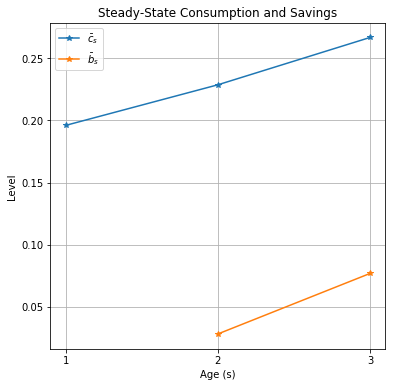

{'b_ss': array([0.02817716, 0.07686583]),
 'c_ss': array([0.1959755 , 0.22861645, 0.26669351]),
 'w_ss': 0.2241526567163615,
 'r_ss': 1.8863668551637944,
 'K_ss': 0.10504298717560716,
 'Y_ss': 0.7586705304246083,
 'C_ss': 0.6912854541514564,
 'EulErr_ss': array([-0.00087544, -0.00013795]),
 'RCerr_ss': -5.551115123125783e-17,
 'ss_time': 2.281746}

In [12]:
beta1 = .55
params1 = beta1, sigma, nvec, L, A, alpha, delta, SS_tol
results_ss = get_SS(params1, np.array([.1, .1]), True)
results_ss

When $\beta$ increases, the steady-state levels of savings and consumption both increase (in all ages),  wage increases, and the interest rate decreases. An increase of $\beta$ can be interpreted as the agents becoming more patient. Thus, the increase in savings follows from this intuition. Increased savings leads to an increase in production in future periods, and thus an increase in consumption. The increase in production leads to an increase in wage and a decrease in the interest rate.

### Exercise 2.3: Time Path Iteration (TPI)

In [13]:
# Set additional parameters needed for TPI
T = 25
path_tol = 1e-9
xi = .8
maxIter = 1000

# Solve for SS savings
results_ss = get_SS(params, np.array([.1, .1]), False)
b2bar, b3bar = results_ss['b_ss']

# Guess initial path of aggregate capital 
b21 = .8 * b2bar
b31 = 1.1 * b3bar
K1 = b21 + b31
Kbar = b2bar + b3bar
# Initial guess is a linear capital series
Kpath = np.linspace(K1, Kbar, T)
# Add an extra element to make time indices line up 
Kpath = np.append(Kpath, Kbar)

# Get initial wage and interest rate paths
w_args = A, alpha
r_args = A, alpha, delta
rpath = get_r(Kpath, r_args)
wpath = get_w(Kpath, w_args)
rbar = get_r(Kbar, r_args)
wbar = get_w(Kbar, w_args)
# Add an extra element to make time indices line up (add ss interest rate and wage)
rpath = np.append(rpath, rbar)
wpath = np.append(wpath, wbar)

In [14]:
def eul_b32(b32, *err1_args):
    """ Solve for b32 using only one intertemporal Euler Equation.
    
    Parameters:
       b32: (float) a guess for the savings vector
             that satisfies the intertemporal Euler equation
       err1_args: a tuple with the model parameters  beta, sigma, rpath, wpath, nvec
        
    Returns:
       err: (float) error in intertemporal Euler equation from using b32
    """
    beta, sigma, rpath, wpath, nvec, b21 = err1_args
    
    # Calculate consumption in each period from budget constraints
    c1 = wpath[0] * nvec[1] + (1 + rpath[0]) * b21 - b32
    c2 = (1 + rpath[1]) * b32 + nvec[2] * wpath[1]
    
    # Calculate marginal utility of consumption
    MU1 = c1 ** (-sigma)
    MU2 = c2 ** (-sigma)
    
    # Calculate error from intertemporal Euler Equation
    err = MU1 - beta * (1 + rpath[1]) * MU2
    
    return err
    
def eul_b2t_b3t1(bvec, *err2_args):
    """Solve for b_{2,t} and b_{3,t+1} for t=3,...,T+1 using two
    intertemporal Euler Equations.
    
    Parameters:
        bvec: a 2 element numpy array with a guess for the savings vector
        that satisfies the intertemporal Euler equations
        err2_args: a tuple with the model parameters beta, sigma, rpath, wpath, nvec
        
    Returns:
        err1: (float) error in intertemporal Euler equation from using bvec
        err2: (float) error in intertemporal Euler equation from using bvec
    
    """
    
    # rpath has two elements: r_2 and r_3
    # wpath has three elements: w_1, w_2, and w_3
    beta, sigma, rpath, wpath, nvec = err2_args 
    
    # Calculate consumption in each period from budget constraints
    c1 = nvec[0] * wpath[0] - bvec[0]
    c2 = nvec[1] * wpath[1] + (1 + rpath[0]) * bvec[0] - bvec[1]
    c3 = (1 + rpath[1]) * bvec[1] + nvec[2] * wpath[2]
    
    # Calculate marginal utility of consumption
    MU1 = c1 ** (-sigma)
    MU2 = c2 ** (-sigma)
    MU3 = c3 ** (-sigma)
    
    # Calculate error from intertemporal Euler Equations
    err1 = MU1 - beta * (1 + rpath[0]) * MU2
    err2 = MU2 - beta * (1 + rpath[1]) * MU3
    
    return err1, err2

In [15]:
eps = path_tol + 1
it = 1
bvec_guess = np.array([.1, .1])

# Solve for time-path equilibrium of aggregate capital
while (it < maxIter and eps > path_tol):
    bmat = np.zeros((T+1,2))
    EulErrs = np.zeros((T+1, 2))
    
    bmat[0,0] = b21
    bmat[0,1] = b31
    
    # Solve for b32
    err1_args = beta, sigma, rpath[:2], wpath[:2], nvec, b21
    result1 = opt.root(eul_b32, bmat[0,1], args=(err1_args))
    bmat[1,1] = result1.x
    EulErrs[1,1] = result1.fun
    
    # Solve for b_{2,t} and b_{3,t+1} using the twisted donut method
    for tt in range(1,T):
        # Solve for b_{2,t} and b_{3,t+1}
        err2_args = beta, sigma, rpath[tt:tt+2], wpath[tt-1:tt+2], nvec
        result2 = opt.root(eul_b2t_b3t1, bvec_guess, args=(err2_args))
        bmat[tt,0] = result2.x[0]
        bmat[tt+1,1] = result2.x[1]
        EulErrs[tt,0] = result2.fun[0]
        EulErrs[tt+1,1] = result2.fun[1]
    
    # Calculate maximum of the absolute values of all the Euler 
    # errors across the entire time path.
    max_AbsEulErrs = np.abs(EulErrs).max(axis = 0)
    
    # Calculate new aggregate capital levels
    Kpath_prime = bmat[:-1].sum(axis=1)
    Kpath_prime = np.append(Kpath_prime, Kbar)
    
    # Calculate difference from last capital series (using L2 norm)
    eps = la.norm(Kpath_prime - Kpath, 2)
    
    # Update capital series
    Kpath_new = xi * Kpath_prime + (1 - xi) * Kpath
    Kpath = np.copy(Kpath_new)
    
    # Update interest rates and wages
    rpath = get_r(Kpath, r_args)
    wpath = get_w(Kpath, w_args)
    
    it = it + 1 

#### Maximum of the absolute values of all the Euler errors across the entire time path

In [16]:
print(max_AbsEulErrs)

[4.77427875e-10 1.96992289e-09]


#### Maximum of the absolute value of all the aggregate resource constraint errors

In [17]:
Yt = A * (Kpath[:-1] ** alpha) * (L **(1 - alpha))
Ct = L * wpath[:-1] + (1 + rpath[:-1]) * bmat[:-1,0] - bmat[1:,0] + (1 + rpath[:-1]) * bmat[:-1,1] - bmat[1:,1]
agg_RC_Err = Yt - Ct - Kpath[1:] + (1 - delta) * Kpath[:-1]
max_agg_RC_Err = np.abs(agg_RC_Err).max()
print(max_agg_RC_Err)

0.01931368363891516


#### Plot Equilibrium Time Paths of Aggregate Capital Stocks, Wage, and Interest Rate

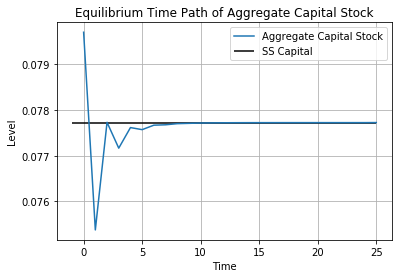

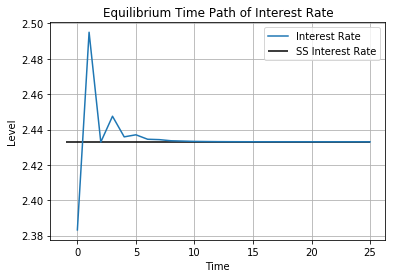

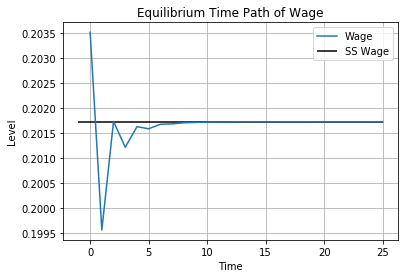

In [18]:
plt.plot(Kpath, label='Aggregate Capital Stock')
plt.hlines(Kbar, -1, T, label='SS Capital')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Equilibrium Time Path of Aggregate Capital Stock')
plt.legend()
plt.show()

plt.plot(rpath, label='Interest Rate')
plt.hlines(rbar, -1, T, label='SS Interest Rate')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Equilibrium Time Path of Interest Rate')
plt.legend()
plt.show()

plt.plot(wpath, label='Wage')
plt.hlines(wbar, -1, T, label='SS Wage')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Equilibrium Time Path of Wage')
plt.legend()
plt.show()

#### How many periods did it take for the economy to get within 0.00001 of the steady-state aggregate capital stock $\bar{K}$?

In [19]:
Kpath_dist_ss = np.abs(Kpath - Kbar)
err =  .00001
# Find first period where capital got within 0.00001 of the steady-state aggregate capital stock 
firstLoc = np.where(Kpath_dist_ss < err)[0]
firstLoc[0]

2

#### What is the period after which the aggregate capital stock never is again farther than 0.00001 away from the steady-state?

In [20]:
loc_cons = np.ediff1d(firstLoc) == 1
firstLoc[-len(loc_cons)]

10